# Proyecto - Feature Engineering
Andrea Cecilia Rivas Castañeda - 16001120

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.impute import KNNImputer, SimpleImputer

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

In [2]:
pd.pandas.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('kidney_disease.csv')
data.head()

id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr    bu   sc    sod  pot  hemo pcv    wc   rc  htn   dm cad appet   pe  \
0  121.0  36.0  1.2    NaN  NaN  15.4  44  7800  5.2  yes  yes  no  good   no   
1    NaN  18.0  0.8    NaN  NaN  11.3  38  6000  NaN   no   no  no  good   no   
2  423.0  53.0  1.8    NaN  NaN   9.6  31  7500  NaN   no  yes  no  poor   no   
3  117.0  56.0  3.8  111.0  2.5  11.2  32  6700  3.9  yes   no  no  poor  yes   
4  106.0  26.0  1.4    NaN  NaN  11.6  35  7300  4.6   no   no  no  good   no   

   ane classification  
0   no            ckd  
1   no            ckd  
2  yes            ckd  
3  yes            ckd  
4   no            ckd

* Separamos el dataset en 2 partes: *entrenamiento* y *prueba*

In [4]:
#separamos data para entrenamiento y prueba,
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['id', 'classification'], axis=1),
                        data['classification'],
                        test_size=0.15,
                        random_state=2021)

* Separación de variables categóricas y numéricas *(discretas y continuas)*.

In [5]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O' and (var not in ['rc', 'pcv', 'wc'])]
num_vars = [var for var in X_train.columns if var not in (cat_vars)]

discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20))]
cont_vars = [var for var in num_vars if var not in discrete_vars]

# Tratamiento de NA's

In [6]:
imputation_types = ['_mean', '_mode', '_median', '_num', '_knn', '_rand']

def graph_density(var, selected):
    sns.set_palette("Set2")
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(121)

    sns.kdeplot(X_train_copy[var], shade=True, label=var)
    for impType in imputation_types:
        sns.kdeplot(X_train_copy[var+impType], shade=True, label=var+impType)
        plt.legend()
    ax2 = fig.add_subplot(122)
    sns.kdeplot(X_train_copy[var], shade=True, label=var)
    sns.kdeplot(X_train_copy[selected], shade=True, label=selected)
    plt.legend()
    plt.show()

In [7]:
def imputation_Methods(var, num, range):
    # Imputación por Media
    X_train_copy[var+'_mean'] = X_train[var].fillna(X_train_copy[var].mean())
    # Imputación por Moda
    X_train_copy[var+'_mode'] = X_train[var].fillna(X_train[var].mode()[0])
    # Imputación por Mediana
    X_train_copy[var+'_median'] = X_train[var].fillna(X_train[var].median())
    # Imputación por un solo valor random
    X_train_copy[var+'_num'] = X_train[var].fillna(num)
    # Imputación por KNN
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    knn_Imp = imputer.fit_transform(np.array(X_train_copy[var]).reshape(-1, 1))
    X_train_copy[var+'_knn'] = knn_Imp
    # Imputación por random
    random.seed(8)
    X_train_copy[var+'_rand'] = X_train[var].fillna(random.uniform(range[0], range[1]))

## Tratamiento de valores especiales
#### pcv
* Tratamiento especial: los valores con chars los convertimos en Na y convertimos la columna en número

In [8]:
X_train['pcv'] = pd.to_numeric(X_train['pcv'].replace(to_replace='\t+', value=pd.NA, regex=True))
X_test['pcv'] = pd.to_numeric(X_test['pcv'].replace(to_replace='\t+', value=pd.NA, regex=True))

#### wc

In [9]:
for k,v in enumerate(X_train.wc):
    if(isinstance(v, str)):
        X_train.wc[k] = v.strip()
        if not(v.isnumeric()):
            X_train.wc[k] = None

for k,v in enumerate(X_test.wc):
    if(isinstance(v, str)):
        X_test.wc[k] = v.strip()
        if not(v.isnumeric()):
            X_test.wc[k] = None

In [10]:
X_train.wc = X_train.wc.astype(float)
X_test.wc = X_test.wc.astype(float)

#### rc

In [11]:
X_train['rc'] = pd.to_numeric(X_train['rc'].replace(to_replace='\t+', value=pd.NA, regex=True))
X_test['rc'] = pd.to_numeric(X_test['rc'].replace(to_replace='\t+', value=pd.NA, regex=True))

* Creamos una copia del dataset X_train para realizar el análisis de datos faltantes.

In [12]:
X_train_copy = X_train.copy()

## Variables Numéricas
### Variables Discretas

In [13]:
X_train[discrete_vars].isnull().mean().sort_values(ascending=False)

sg    0.108824
su    0.108824
al    0.100000
bp    0.029412
dtype: float64

#### sg

In [14]:
X_train['sg'].describe()

count    303.000000
mean       1.017442
std        0.005767
min        1.005000
25%        1.010000
50%        1.020000
75%        1.020000
max        1.025000
Name: sg, dtype: float64

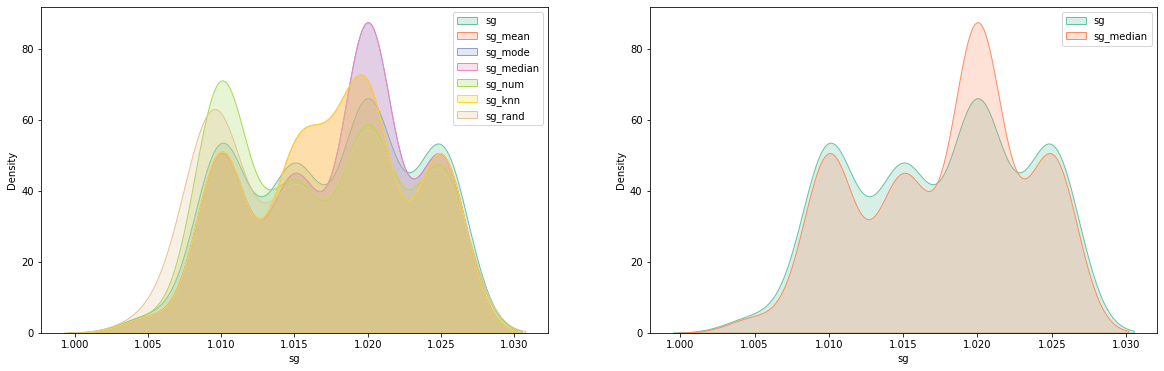

In [15]:
imputation_Methods('sg', 1.01, [1.002, 1.03])
graph_density('sg', 'sg_median')

In [16]:
X_train['sg'] = X_train['sg'].fillna(X_train['sg'].median())
X_test['sg'] = X_test['sg'].fillna(X_train['sg'].median())

#### al

In [17]:
X_train['al'].describe()

count    306.000000
mean       1.000000
std        1.357432
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: al, dtype: float64

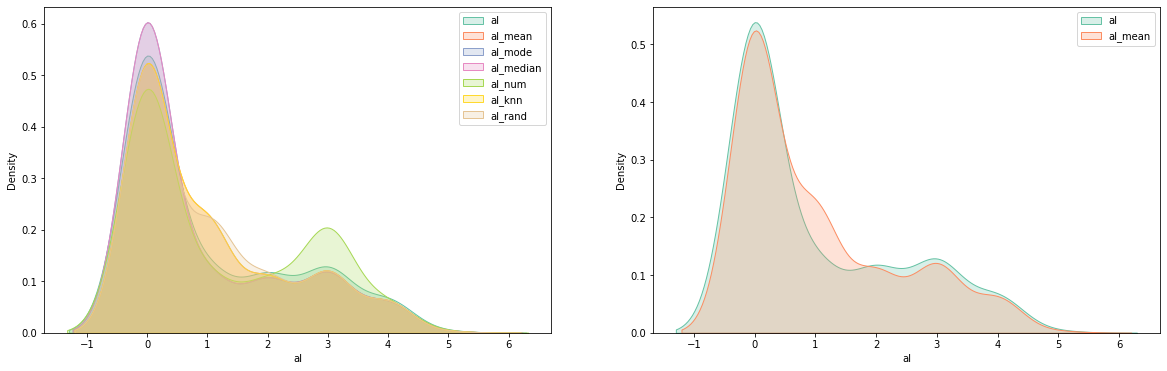

In [18]:
imputation_Methods('al', 3, [0,5])
graph_density('al', 'al_mean')

* Se seleccinó imputación por media.

In [19]:
X_train['al'] = X_train['al'].fillna(X_train['al'].mean())
X_test['al'] = X_test['al'].fillna(X_train['al'].mean())

#### su

In [20]:
X_train_copy['su'].describe()

count    303.000000
mean       0.475248
std        1.129913
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: su, dtype: float64

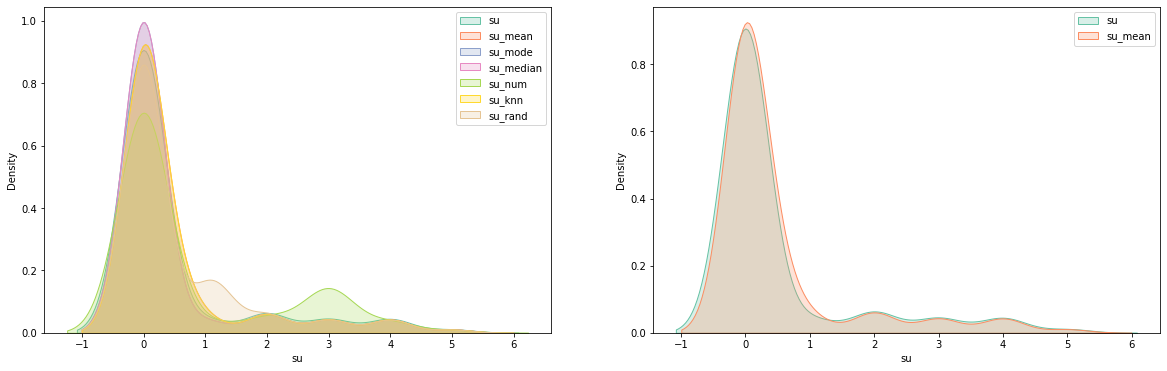

In [21]:
imputation_Methods('su', 3, [0,5])
graph_density('su', 'su_mean')

In [22]:
X_train['su'] = X_train['su'].fillna(X_train['su'].mean())
X_test['su'] = X_test['su'].fillna(X_train['su'].mean())

#### bp

In [23]:
X_train_copy['bp'].describe()

count    330.000000
mean      76.151515
std       14.013934
min       50.000000
25%       70.000000
50%       75.000000
75%       80.000000
max      180.000000
Name: bp, dtype: float64

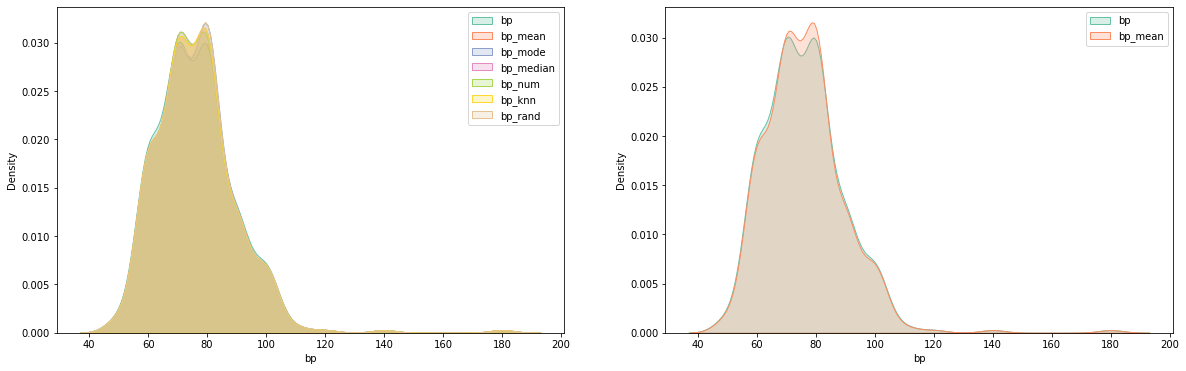

In [24]:
imputation_Methods('bp', 75, [50,180])
graph_density('bp', 'bp_mean')

In [25]:
X_train['bp'] = X_train['bp'].fillna(X_train['bp'].mean())
X_test['bp'] = X_test['bp'].fillna(X_train['bp'].mean())

### Variables Continuas

In [26]:
cont_vars = [var for var in num_vars if var not in discrete_vars]
cont_vars

['age', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

#### age

In [27]:
X_train_copy['age'].describe()

count    331.000000
mean      50.646526
std       17.415218
min        2.000000
25%       41.000000
50%       54.000000
75%       63.000000
max       83.000000
Name: age, dtype: float64

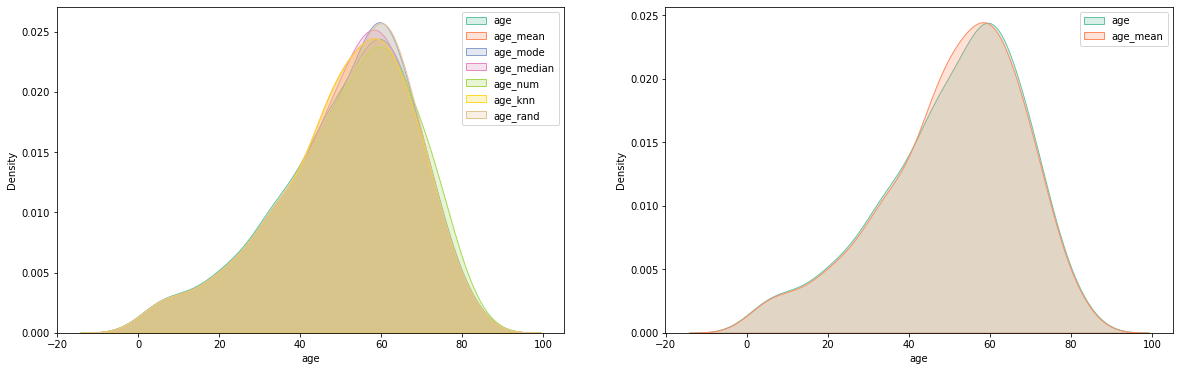

In [28]:
imputation_Methods('age', 75, [50,100])
graph_density('age', 'age_mean')

In [29]:
X_train['age'] = X_train['age'].fillna(X_train['age'].mean())
X_test['age'] = X_test['age'].fillna(X_train['age'].mean())

#### bgr

In [30]:
X_train_copy['bgr'].describe()

count    298.000000
mean     150.000000
std       82.408362
min       22.000000
25%      100.000000
50%      122.000000
75%      165.000000
max      490.000000
Name: bgr, dtype: float64

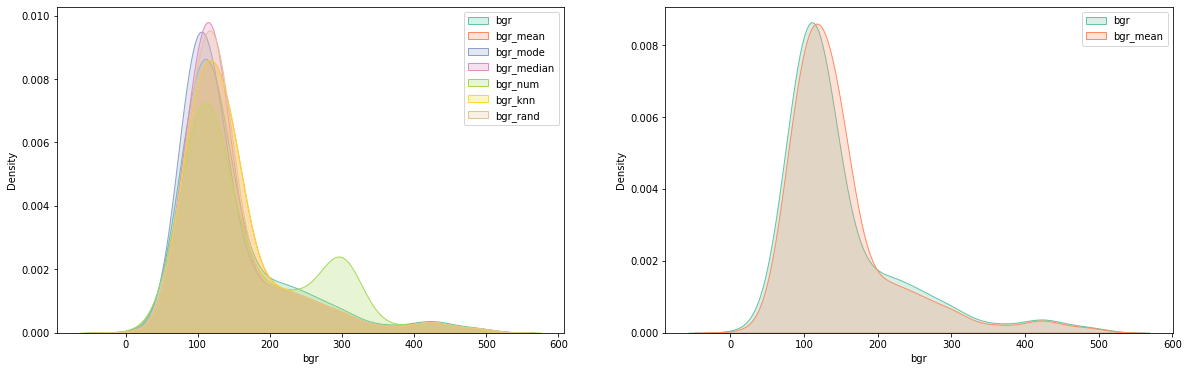

In [31]:
imputation_Methods('bgr', 300, [22,500])
graph_density('bgr', 'bgr_mean')

In [32]:
X_train['bgr'] = X_train['bgr'].fillna(X_train['bgr'].mean())
X_test['bgr'] = X_test['bgr'].fillna(X_train['bgr'].mean())

#### bu

In [33]:
X_train_copy['bu'].describe()

count    325.000000
mean      56.336000
std       51.735323
min        1.500000
25%       26.000000
50%       40.000000
75%       60.000000
max      391.000000
Name: bu, dtype: float64

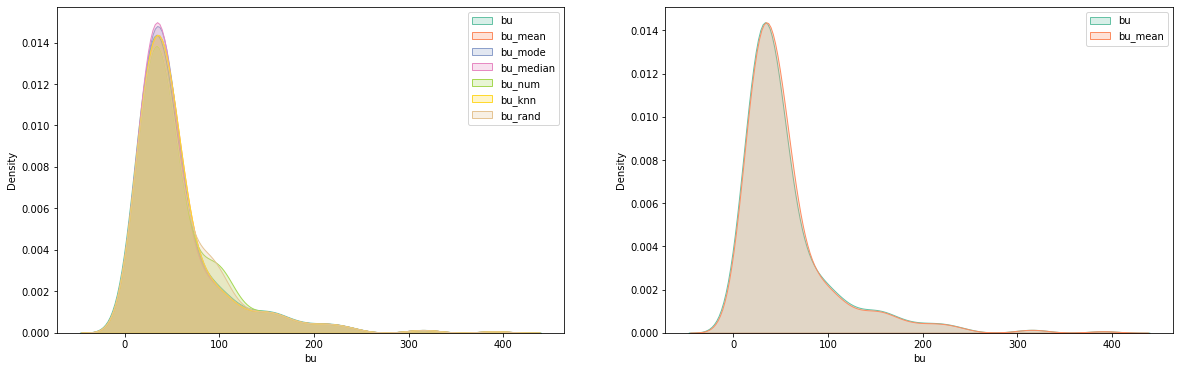

In [34]:
imputation_Methods('bu', 100, [2,400])
graph_density('bu', 'bu_mean')

In [35]:
X_train['bu'] = X_train['bu'].fillna(X_train['bu'].mean())
X_test['bu'] = X_test['bu'].fillna(X_train['bu'].mean())

#### sc

In [36]:
X_train_copy['sc'].describe()

count    326.000000
mean       3.122699
std        6.096383
min        0.400000
25%        0.900000
50%        1.200000
75%        2.800000
max       76.000000
Name: sc, dtype: float64

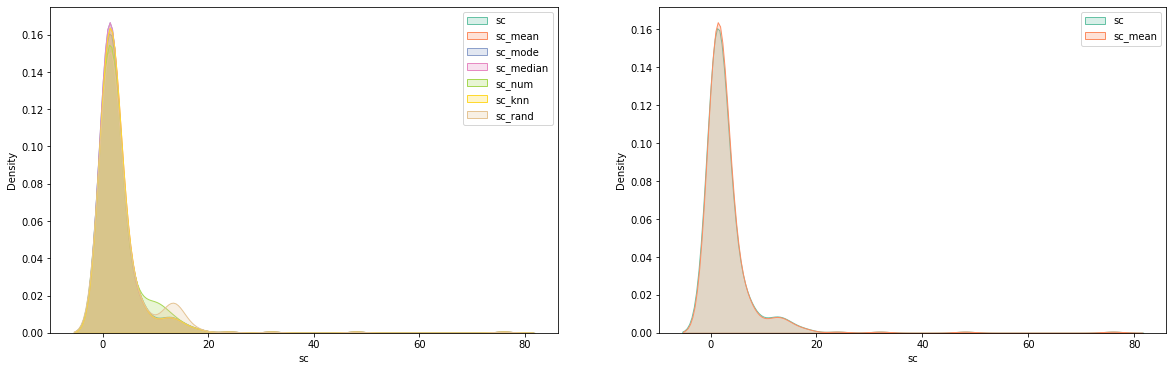

In [37]:
imputation_Methods('sc', 10, [0,60])
graph_density('sc', 'sc_mean')

In [38]:
X_train['sc'] = X_train['sc'].fillna(X_train['sc'].mean())
X_test['sc'] = X_test['sc'].fillna(X_train['sc'].mean())

#### sod

In [39]:
X_train_copy['sod'].describe()

count    273.000000
mean     137.368132
std       10.894591
min        4.500000
25%      135.000000
50%      138.000000
75%      142.000000
max      163.000000
Name: sod, dtype: float64

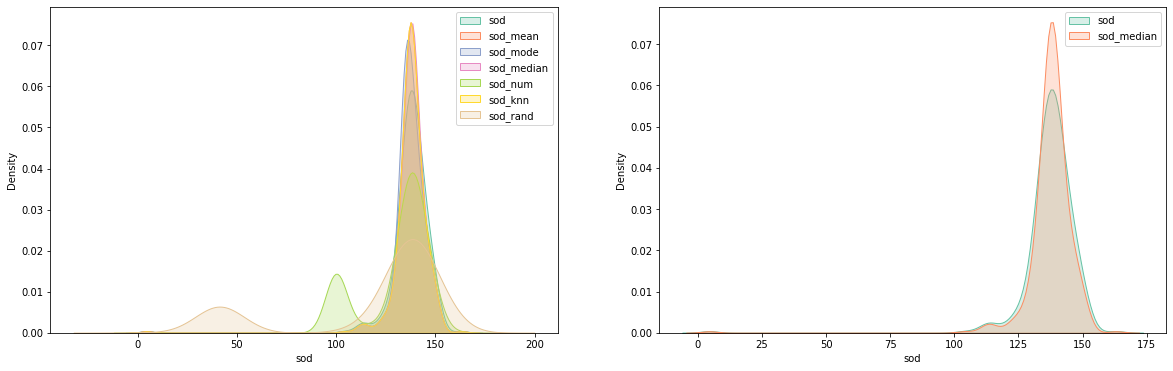

In [40]:
imputation_Methods('sod', 100, [5,165])
graph_density('sod', 'sod_median')

In [41]:
X_train['sod'] = X_train['sod'].fillna(X_train['sod'].median())
X_test['sod'] = X_test['sod'].fillna(X_train['sod'].median())

#### pot

In [42]:
X_train_copy['pot'].describe()

count    272.000000
mean       4.661765
std        3.407352
min        2.500000
25%        3.800000
50%        4.400000
75%        4.900000
max       47.000000
Name: pot, dtype: float64

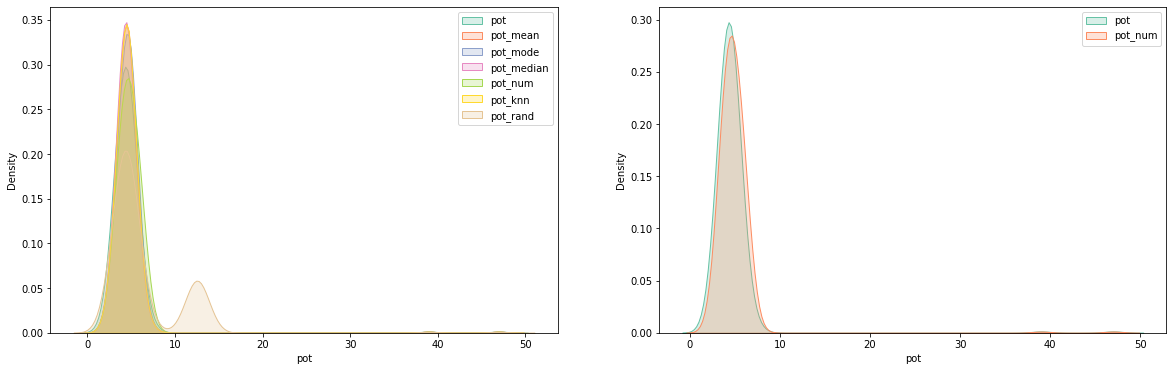

In [43]:
imputation_Methods('pot', 6, [3,45])
graph_density('pot', 'pot_num')

In [44]:
X_train['pot'] = X_train['pot'].fillna(6)
X_test['pot'] = X_test['pot'].fillna(6)

#### hemo

In [45]:
X_train['hemo'].describe()

count    298.000000
mean      12.611409
std        2.938117
min        3.100000
25%       10.625000
50%       13.000000
75%       15.000000
max       17.800000
Name: hemo, dtype: float64

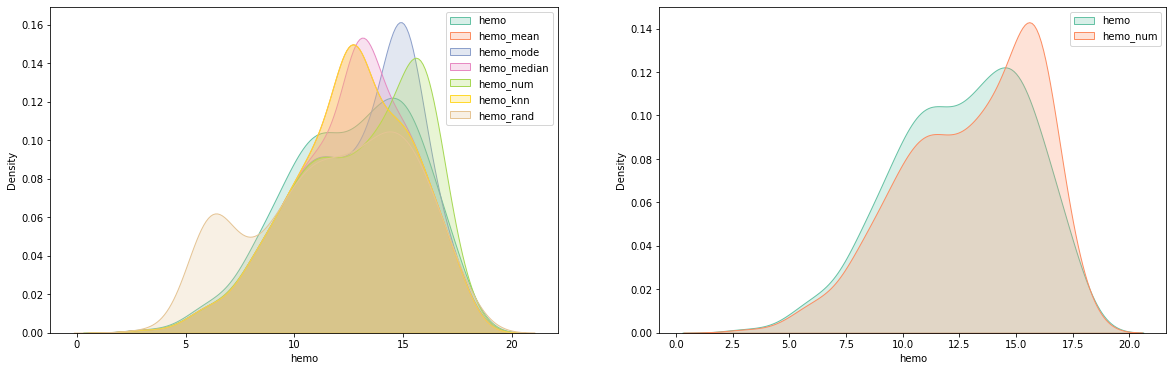

In [46]:
imputation_Methods('hemo', 16, [3,17])
graph_density('hemo', 'hemo_num')

In [47]:
X_train['hemo'] = X_train['hemo'].fillna(16)
X_test['hemo'] = X_test['hemo'].fillna(16)

#### pcv

In [48]:
X_train['pcv'].describe()

count    283.000000
mean      39.038869
std        9.073493
min        9.000000
25%       32.500000
50%       41.000000
75%       45.000000
max       54.000000
Name: pcv, dtype: float64

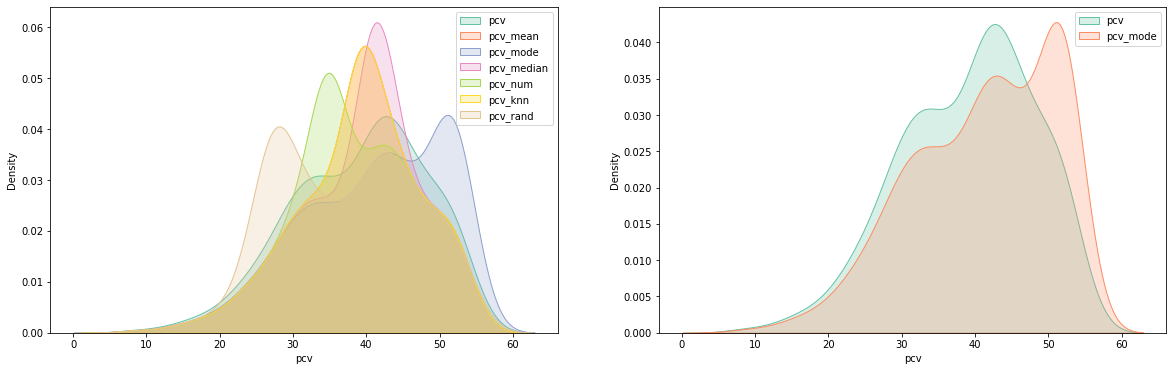

In [49]:
imputation_Methods('pcv', 35, [20,52])
graph_density('pcv', 'pcv_mode')

In [50]:
X_train['pcv'] = X_train['pcv'].fillna(X_train['pcv'].mode()[0])
X_test['pcv'] = X_test['pcv'].fillna(X_train['pcv'].mode()[0])

#### wc

In [51]:
X_train['wc'].describe()

count      322.000000
mean      8154.037267
std       2850.206175
min       4200.000000
25%       6300.000000
50%       7500.000000
75%       9475.000000
max      21600.000000
Name: wc, dtype: float64

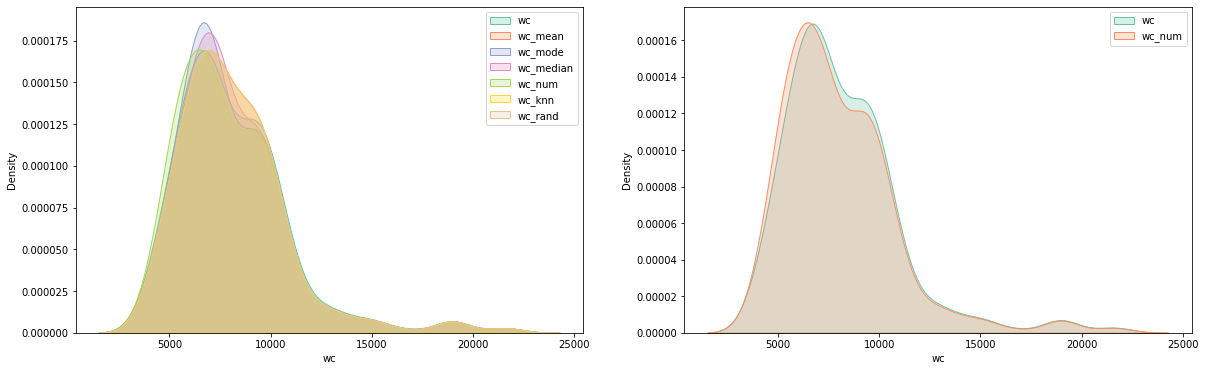

In [52]:
imputation_Methods('wc', 5352, [4250,21550])
graph_density('wc', 'wc_num')

In [53]:
X_train['wc'] = X_train['wc'].fillna(5352)
X_test['wc'] = X_test['wc'].fillna(5352)

#### rc

In [54]:
X_train['rc'].describe()

count    230.000000
mean       4.728696
std        1.037192
min        2.100000
25%        4.000000
50%        4.800000
75%        5.500000
max        8.000000
Name: rc, dtype: float64

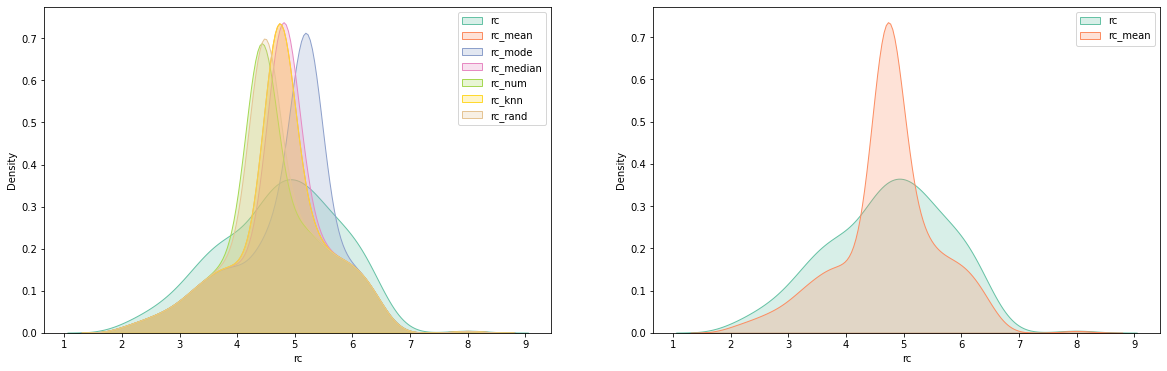

In [55]:
imputation_Methods('rc', 4.4, [4,6])
graph_density('rc', 'rc_mean')

In [56]:
X_train['rc'] = X_train['rc'].fillna(X_train['rc'].mean())
X_test['rc'] = X_test['rc'].fillna(X_train['rc'].mean())

## Variables Categóricas

In [57]:
X_train[cat_vars].isnull().mean()

rbc      0.350000
pc       0.152941
pcc      0.011765
ba       0.011765
htn      0.005882
dm       0.005882
cad      0.005882
appet    0.002941
pe       0.002941
ane      0.002941
dtype: float64

#### rbc

In [58]:
X_train['rbc'].value_counts()/X_train.shape[0]

normal      0.532353
abnormal    0.117647
Name: rbc, dtype: float64

In [59]:
X_train['rbc'] = X_train['rbc'].fillna('undefined')
X_test['rbc'] = X_test['rbc'].fillna('undefined')

#### pc

In [60]:
X_train['pc'].value_counts()/X_train.shape[0]

normal      0.650000
abnormal    0.197059
Name: pc, dtype: float64

In [61]:
X_train['pc'] = X_train['pc'].fillna('undefined')
X_test['pc'] = X_test['pc'].fillna('undefined')

#### pcc

In [62]:
X_train['pcc'].value_counts()/X_train.shape[0]

notpresent    0.876471
present       0.111765
Name: pcc, dtype: float64

In [63]:
X_train['pcc'] = X_train['pcc'].fillna('undefined')
X_test['pcc'] = X_test['pcc'].fillna('undefined')

#### ba

In [64]:
X_train['ba'].value_counts()/X_train.shape[0]

notpresent    0.932353
present       0.055882
Name: ba, dtype: float64

In [65]:
X_train['ba'] = X_train['ba'].fillna('undefined')
X_test['ba'] = X_test['ba'].fillna('undefined')

#### htn

In [66]:
X_train['htn'].value_counts()/X_train.shape[0]

no     0.644118
yes    0.350000
Name: htn, dtype: float64

In [67]:
X_train['htn'] = X_train['htn'].fillna('undefined')
X_test['htn'] = X_test['htn'].fillna('undefined')

#### dm

In [68]:
X_train['dm'].value_counts()/X_train.shape[0]

no       0.664706
yes      0.317647
\tno     0.005882
 yes     0.002941
\tyes    0.002941
Name: dm, dtype: float64

In [69]:
X_train['dm'] = X_train['dm'].fillna('undefined')
X_test['dm'] = X_test['dm'].fillna('undefined')

#### cad

In [70]:
X_train['cad'].value_counts()/X_train.shape[0]

no      0.905882
yes     0.085294
\tno    0.002941
Name: cad, dtype: float64

In [71]:
X_train['cad'] = X_train['cad'].fillna('undefined')
X_test['cad'] = X_test['cad'].fillna('undefined')

#### appet

In [72]:
X_train['appet'].value_counts()/X_train.shape[0]

good    0.791176
poor    0.205882
Name: appet, dtype: float64

In [73]:
X_train['appet'] = X_train['appet'].fillna('medium')
X_test['appet'] = X_test['appet'].fillna('medium')

#### pe

In [74]:
X_train['pe'].value_counts()/X_train.shape[0]

no     0.814706
yes    0.182353
Name: pe, dtype: float64

In [75]:
X_train['pe'] = X_train['pe'].fillna('undefined')
X_test['pe'] = X_test['pe'].fillna('undefined')

#### ane

In [76]:
X_train['ane'].value_counts()/X_train.shape[0]

no     0.858824
yes    0.138235
Name: ane, dtype: float64

In [77]:
X_train['ane'] = X_train['ane'].fillna('undefined')
X_test['ane'] = X_test['ane'].fillna('undefined')

## Transformación de Variables Numéricas
### Variables Continuas

In [78]:
X_train[cont_vars].head()

age    bgr    bu   sc    sod  pot  hemo   pcv       wc        rc
397  12.0  100.0  26.0  0.6  137.0  4.4  15.8  49.0   6600.0  5.400000
158  71.0  424.0  48.0  1.5  132.0  4.0  10.9  31.0  13200.0  4.728696
282  20.0  123.0  44.0  1.0  135.0  3.8  14.6  44.0   4200.0  4.800000
1     7.0  150.0  18.0  0.8  138.0  6.0  11.3  38.0   6000.0  4.728696
370  69.0   83.0  42.0  1.2  139.0  3.7  16.2  50.0   9300.0  5.400000

In [79]:
def transform(df, var):
    X_train_copy = df.copy()
    X_train_copy[var+'_yj'], param = stats.yeojohnson(X_train_copy[var])
    X_train_copy[var+'_log'] = np.log(X_train_copy[var] + 1)
    X_train_copy[var+'_sqrt'] = np.sqrt(X_train_copy[var])
    X_train_copy[var+'_inv'] = 1/(X_train_copy[var]+1)
    X_train_copy[var+'_pow'] = (X_train_copy[var]**2)
    return X_train_copy[[col for col in X_train_copy.columns if var in col]]

In [80]:
def graph_densityTrans(df, var):
    df = transform(df, var)
    fig, axs = plt.subplots(2, 3, figsize=(14, 7))
    sns.distplot( a=df[var], hist=True, kde=True, rug=False, color="skyblue", ax=axs[0, 0])
    sns.distplot( a=df[var+'_yj'], hist=True, kde=True, rug=False, color='#4dac26', ax=axs[0, 1])
    sns.distplot( a=df[var+'_log'], hist=True, kde=True, rug=False, color="gold", ax=axs[0, 2])
    sns.distplot( a=df[var+'_sqrt'], hist=True, kde=True, rug=False, color="#7b3294", ax=axs[1, 0])
    sns.distplot( a=df[var+'_inv'], hist=True, kde=True, rug=False, color="pink", ax=axs[1, 1])
    sns.distplot( a=df[var+'_pow'], hist=True, kde=True, rug=False, color="orange", ax=axs[1, 2])
    plt.show()

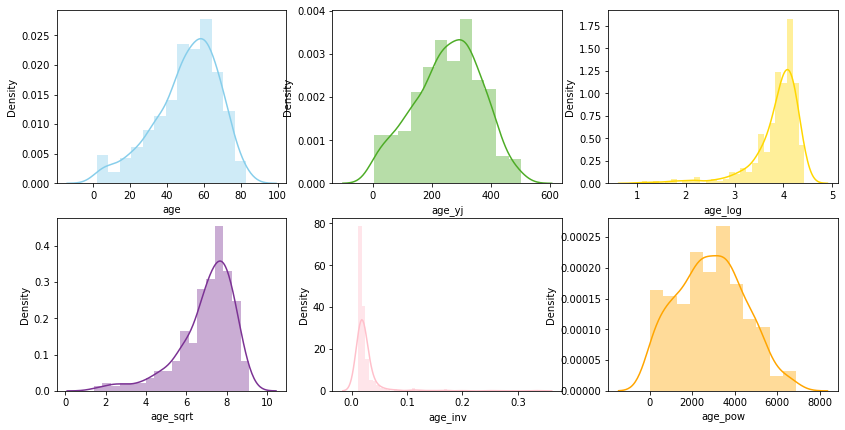

In [81]:
# AGE
graph_densityTrans(X_train, 'age')

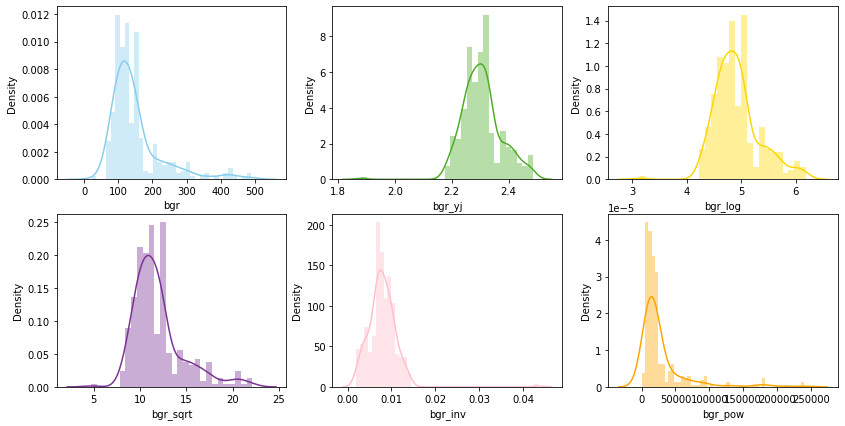

In [82]:
# BGR
graph_densityTrans(X_train, 'bgr')

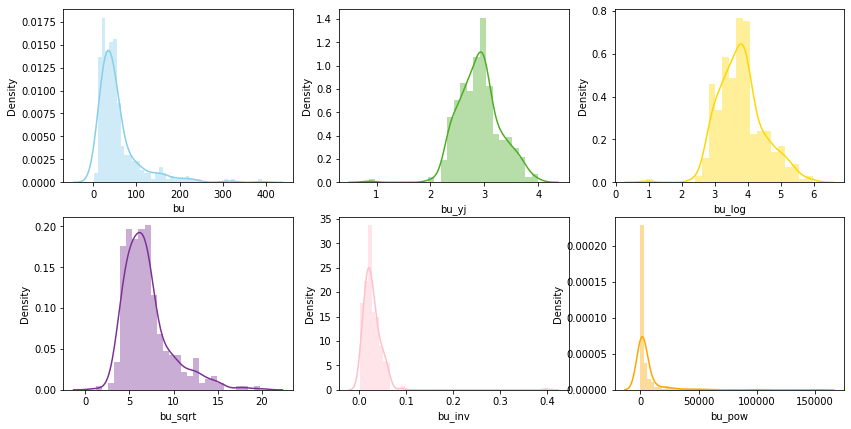

In [83]:
# BU
graph_densityTrans(X_train, 'bu')

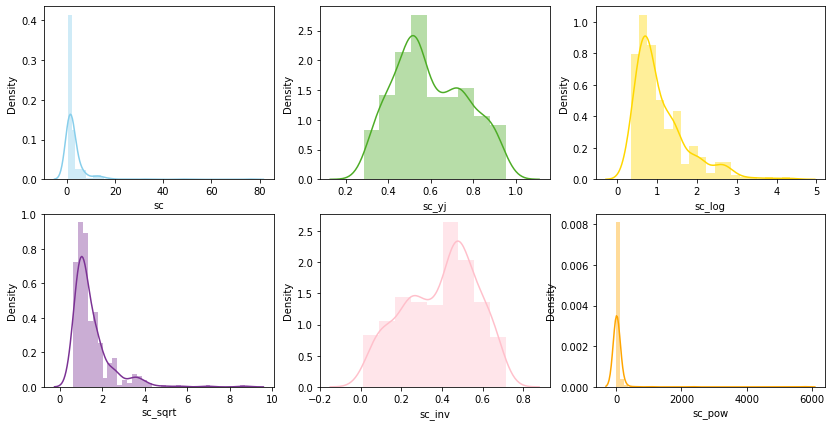

In [84]:
# SC
graph_densityTrans(X_train, 'sc')

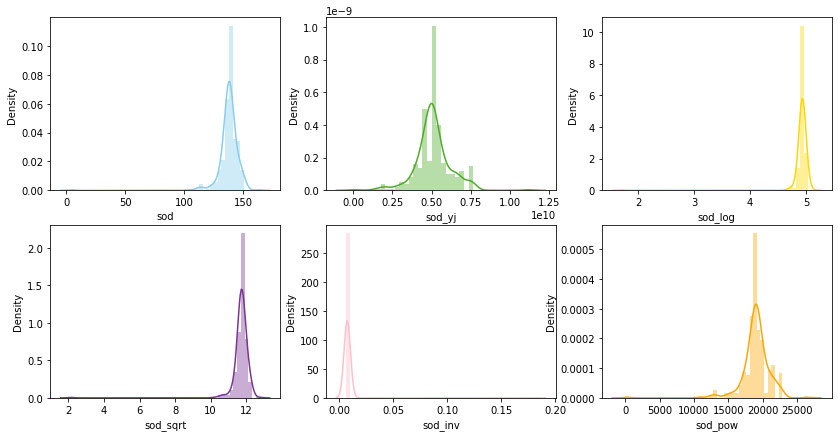

In [85]:
# SOD
graph_densityTrans(X_train, 'sod')

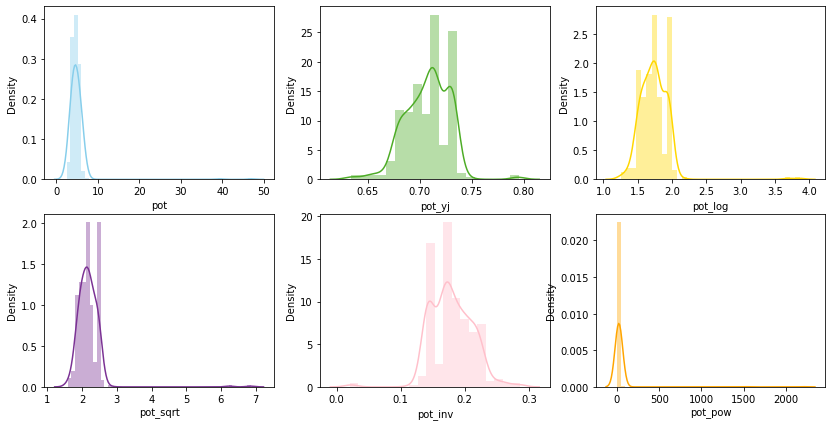

In [86]:
# POT
graph_densityTrans(X_train, 'pot')

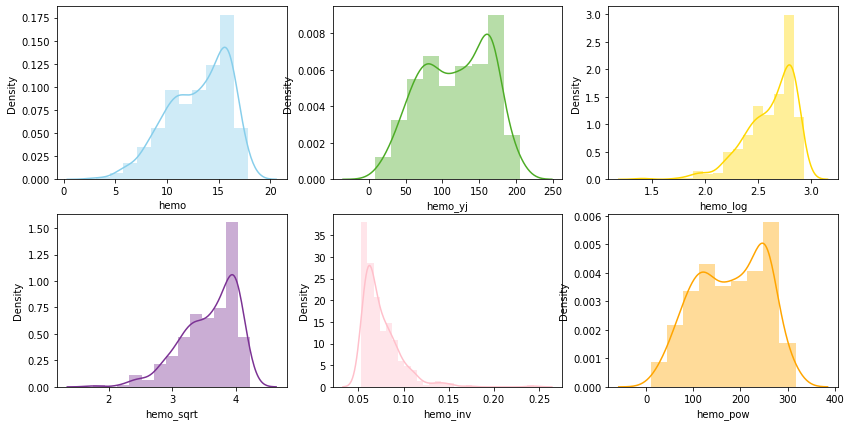

In [87]:
# HEMO
graph_densityTrans(X_train, 'hemo')

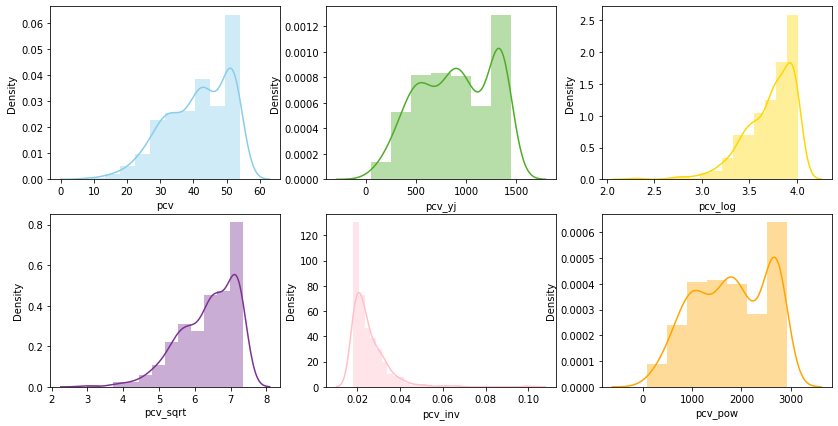

In [88]:
# PCV
graph_densityTrans(X_train, 'pcv')

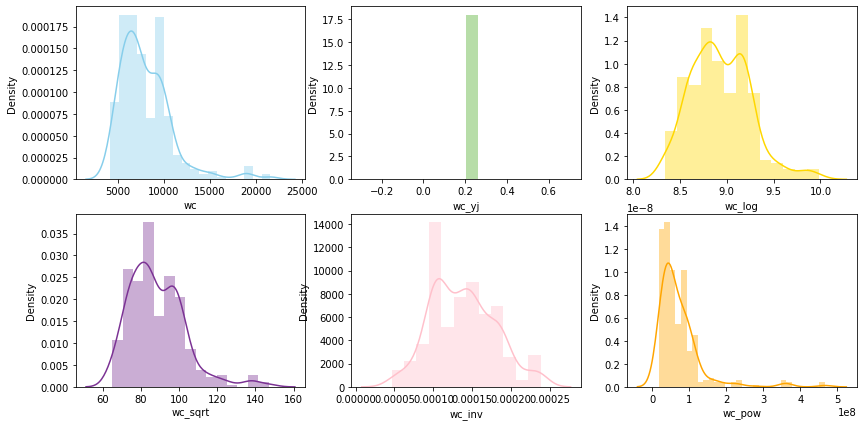

In [89]:
# WC
graph_densityTrans(X_train, 'wc')

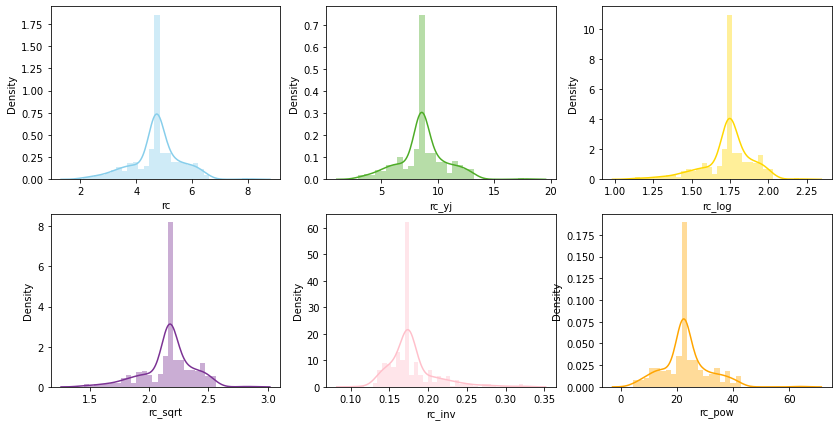

In [90]:
# RC
graph_densityTrans(X_train, 'rc')

* age: se eleccionó la transformación Yeo-Johnson
* bgr: se eleccionó la transformación sqrt
* bu: se eleccionó la transformación logaritmica
* sc: se eleccionó la transformación Yeo-Johnson
* sod: se eleccionó la transformación Yeo-Johnson
* pot: se eleccionó la transformación Yeo-Johnson
* hemo: se eleccionó la transformación Yeo-Johnson
* pcv: se eleccionó la transformación Yeo-Johnson
* wc: se eleccionó la transformación inversa
* rc: se seleccionó la original

In [91]:
X_train['age'], _ = stats.yeojohnson(X_train['age'])
X_test['age'], _ = stats.yeojohnson(X_test['age'])

X_train['bgr'] = np.sqrt(X_train['bgr'])
X_test['bgr'] = np.sqrt(X_test['bgr'])

X_train['bu'] = np.log(X_train['bu'] + 1)
X_test['bu'] = np.log(X_test['bu'] + 1)

X_train['sc'], _ = stats.yeojohnson(X_train['sc'])
X_test['sc'], _ = stats.yeojohnson(X_test['sc'])

X_train['sod'], _ = stats.yeojohnson(X_train['sod'])
X_test['sod'], _ = stats.yeojohnson(X_test['sod'])

X_train['pot'], _ = stats.yeojohnson(X_train['pot'])
X_test['pot'], _ = stats.yeojohnson(X_test['pot'])

X_train['hemo'], _ = stats.yeojohnson(X_train['hemo'])
X_test['hemo'], _ = stats.yeojohnson(X_test['hemo'])

X_train['pcv'], _ = stats.yeojohnson(X_train['pcv'])
X_test['pcv'], _ = stats.yeojohnson(X_test['pcv'])

X_train['wc'] = 1/(X_train['wc']+1)
X_test['wc'] = 1/(X_test['wc']+1)

### Variables Discretas
Binarización de variables con sesgo fuerte

In [92]:
def binarizer(df, var, threshold):
    df[var] = np.where(df[var] >= threshold, 1, 0)
    return df[var]

In [93]:
X_train['al'] = binarizer(X_train, 'al', 1)
X_test['al'] = binarizer(X_test, 'al', 1)

X_train['su'] = binarizer(X_train, 'su', 1)
X_test['su'] = binarizer(X_test, 'su', 1)

## Transformación de Variables Categóricas

In [94]:
cat_vars

['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [95]:
# NORMAL MAPPING
normal_mapping = {'normal':1, 'undefined': 0, 'abnormal':-1}
X_train['rbc'] = X_train['rbc'].map(normal_mapping)
X_test['rbc'] = X_test['rbc'].map(normal_mapping)

X_train['pc'] = X_train['pc'].map(normal_mapping)
X_test['pc'] = X_test['pc'].map(normal_mapping)

In [96]:
# PRESENCE MAPPING
presence_mapping = {'notpresent':1, 'undefined': 0, 'present':-1}
X_train['pcc'] = X_train['pcc'].map(presence_mapping)
X_test['pcc'] = X_test['pcc'].map(presence_mapping)

X_train['ba'] = X_train['ba'].map(presence_mapping)
X_test['ba'] = X_test['ba'].map(presence_mapping)

In [97]:
# YES/NO MAPPING
yes_mapping = {'yes':1, '\tyes':1, ' yes':1, 'undefined': 0, 'no':-1, '\tno':-1}
X_train['htn'] = X_train['htn'].map(yes_mapping)
X_test['htn'] = X_test['htn'].map(yes_mapping)

X_train['dm'] = X_train['dm'].map(yes_mapping)
X_test['dm'] = X_test['dm'].map(yes_mapping)

X_train['cad'] = X_train['cad'].map(yes_mapping)
X_test['cad'] = X_test['cad'].map(yes_mapping)

X_train['pe'] = X_train['pe'].map(yes_mapping)
X_test['pe'] = X_test['pe'].map(yes_mapping)

X_train['ane'] = X_train['ane'].map(yes_mapping)
X_test['ane'] = X_test['ane'].map(yes_mapping)

In [98]:
# QUALITY MAPPING
quality_mapping = {'good':1, 'medium': 0, 'poor':-1}
X_train['appet'] = X_train['appet'].map(quality_mapping)
X_test['appet'] = X_test['appet'].map(quality_mapping)

In [99]:
X_train.head()

age    bp    sg  al  su  rbc  pc  pcc  ba        bgr        bu  \
397   30.236333  80.0  1.02   0   0    1   1    1   1  10.000000  3.295837   
158  398.173383  60.0  1.02   1   1    1   1   -1   1  20.591260  3.891820   
282   62.607011  70.0  1.02   0   0    1   1    1   1  11.090537  3.806662   
1     14.292481  50.0  1.02   1   0    0   1    1   1  12.247449  2.944439   
370  381.733471  70.0  1.02   0   0    1   1    1   1   9.110434  3.761200   

           sc           sod       pot        hemo          pcv        wc  \
397  0.371972  4.848990e+09  0.703901  162.539896  1201.157855  0.000151   
158  0.591340  4.054834e+09  0.694043   79.581486   494.244029  0.000076   
282  0.494296  4.517760e+09  0.688417  139.438468   974.028920  0.000238   
1    0.440056  5.021677e+09  0.730957   85.229959   732.691048  0.000167   
370  0.538507  5.199209e+09  0.685402  170.644702  1249.418694  0.000108   

           rc  htn  dm  cad  appet  pe  ane  
397  5.400000   -1  -1   -1      1  -1   -1  
158  4.728696    1   1    1      1  -1   -1  
282  4.800000   -1  -1   -1      1  -1   -1  
1    4.728696   -1  -1   -1      1  -1   -1  
370  5.400000   -1  -1   -1      1  -1   -1

## Transformación de Variable Target

In [100]:
target_mapping = {'notckd':0, 'ckd': 1}
y_train = y_train.map(target_mapping)
y_test = y_test.map(target_mapping)

# Feature Scaling

In [101]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train), columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns
)

In [102]:
X_train.head()

age        bp    sg   al   su  rbc   pc  pcc   ba       bgr        bu  \
0  0.055044  0.230769  0.75  0.0  0.0  1.0  1.0  1.0  1.0  0.304352  0.470734   
1  0.792846  0.076923  0.75  1.0  1.0  1.0  1.0  0.0  1.0  0.911457  0.588634   
2  0.119955  0.153846  0.75  0.0  0.0  1.0  1.0  1.0  1.0  0.366863  0.571788   
3  0.023073  0.000000  0.75  1.0  0.0  0.5  1.0  1.0  1.0  0.433179  0.401219   
4  0.759880  0.153846  0.75  0.0  0.0  1.0  1.0  1.0  1.0  0.253361  0.562794   

         sc       sod       pot      hemo       pcv        wc        rc  htn  \
0  0.131425  0.433189  0.434330  0.783642  0.821334  0.548637  0.559322  0.0   
1  0.459224  0.362242  0.373342  0.361851  0.317632  0.153630  0.445542  1.0   
2  0.314212  0.403598  0.338536  0.666186  0.659496  1.000000  0.457627  0.0   
3  0.233163  0.448616  0.601720  0.390570  0.487534  0.627631  0.445542  0.0   
4  0.380277  0.464476  0.319880  0.824850  0.855721  0.319285  0.559322  0.0   

    dm  cad  appet   pe  ane  
0  0.0  0.0    1.0  0.0  0.0  
1  1.0  1.0    1.0  0.0  0.0  
2  0.0  0.0    1.0  0.0  0.0  
3  0.0  0.0    1.0  0.0  0.0  
4  0.0  0.0    1.0  0.0  0.0

In [103]:
X_test.head()

age        bp    sg   al   su  rbc   pc  pcc   ba       bgr        bu  \
0  0.338843  0.307692  0.75  1.0  1.0  0.5  1.0  1.0  1.0  0.476316  0.588634   
1  0.360547  0.384615  0.50  0.0  0.0  0.5  1.0  1.0  1.0  0.274937  0.727765   
2  0.215672  0.076923  0.75  0.0  0.0  1.0  1.0  1.0  1.0  0.289838  0.580390   
3  0.435053  0.153846  1.00  1.0  0.0  0.5  1.0  1.0  1.0  0.451657  0.592631   
4  0.389960  0.153846  0.25  1.0  1.0  1.0  0.0  0.0  0.0  0.569677  0.723727   

         sc       sod        pot      hemo       pcv        wc        rc  htn  \
0  0.772042  0.046987  24.522982  0.063291  0.467133  0.232636  0.677966  1.0   
1  0.789148  0.046987  71.614725  0.024300  0.162396  0.706623  0.254237  1.0   
2  0.097985  0.046987  42.509862  0.078554  0.526833  0.435784  0.711864  0.0   
3  0.534579  0.042716  50.130607  0.042038  0.568343  0.732835  0.445542  1.0   
4  1.118964  0.025638  38.118835  0.026912  0.162396  0.212026  0.203390  1.0   

    dm  cad  appet   pe  ane  
0  0.0  0.0    1.0  0.0  0.0  
1  0.0  0.0    1.0  0.0  0.0  
2  0.0  0.0    1.0  0.0  0.0  
3  0.0  0.0    0.0  1.0  0.0  
4  1.0  1.0    1.0  1.0  1.0

In [104]:
joblib.dump(scaler, 'minmax_scaler.joblib')

['minmax_scaler.joblib']

In [105]:
#Guardamos dataset con data preparada para entrenamiento.

X_train.to_csv('prep_Xtrain.csv', index=False)
X_test.to_csv('prep_Xtest.csv', index=False)

y_train.to_csv('prep_ytrain.csv', index=False)
y_test.to_csv('prep_ytest.csv', index=False)